In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import stir_simind_utils as utils_ev
# plotting settings
plt.ion() # interactive 'on' such that plots appear during loops
#%% Import SIRF
import sirf.STIR as spect
import sirf.Utilities
import sirf.Reg as Reg
from sirf_simind_connection import SimindSimulator, SimulationConfig, configs, utils
from sirf_simind_connection.core.components import ScoringRoutine
from sirf_simind_connection.utils import get_array
import phantomgen as phantom
import numpy as np
import numexpr as ne
ne.set_num_threads(16) # use only 16 threads
import shutil
from pathlib import Path

In [31]:
# Create output directory
output_dir = Path("/home/evarzaki/PROJECTS/_CLONED_Repositories/STIR_EARL_demo/simind_data/tc99m")
output_dir.mkdir(parents=True, exist_ok=True)


"""Run the basic simulation."""
print("Creating phantom and attenuation map...")
matrix_size = (256,256,256)
#matrix_size = (128,128,128)
voxel_size = (2.2077,2.2077,2.2077)
#voxel_size = (4.4167,4.4167,4.4167)

earl_nema_dict_lu177 = {
    "mu_values":{
        "perspex_mu_value": 0.15,
        "fill_mu_value": 0.14,
        "lung_mu_value": 0.043
    },
    "activity_concentration_background": 0.0,
    "include_lung_insert": False,
    "sphere_dict": {
        "ring_R": 57,
        "ring_z": -37,
        "spheres": {
            "diametre_mm": [13,17,22,28,37,60],
            "angle_loc":   [270,150,30,90,330,210],
            "act_conc_MBq_ml": [1.611,1.611,1.611,1.611,1.611,1.611],
        }
    }
}

earl_nema_dict_tc99m = {
    "mu_values":{
        "perspex_mu_value": 0.175,
        "fill_mu_value": 0.154,
        "lung_mu_value": 0.046
    },
    "activity_concentration_background": 0.0,
    "include_lung_insert": False,
    "sphere_dict": {
        "ring_R": 57,
        "ring_z": -37,
        "spheres": {
            "diametre_mm": [13,17,22,28,37,60],
            "angle_loc":   [270,150,30,90,330,210],
            "act_conc_MBq_ml": [1.013,1.013,1.013,1.013,1.013,1.013],
        }
    }
}

nema_act_arr, nema_ctac_arr = phantom.create_nema(matrix_size=matrix_size, voxel_size_mm=voxel_size, nema_dict=earl_nema_dict_tc99m)

nema_act = spect.ImageData()
nema_act.initialise(dim=matrix_size,vsize=voxel_size)
nema_act.fill(nema_act_arr)
nema_act.write(str(output_dir/ "nema_act"))

nema_ctac = nema_act.clone()
nema_ctac.fill(nema_ctac_arr)
nema_ctac.write(str(output_dir/ "nema_ctac"))

Creating phantom and attenuation map...


In [ ]:
print("Setting up SIMIND simulator using new API...")

# Load and configure the simulation config
config = SimulationConfig("/home/evarzaki/PROJECTS/_CLONED_Repositories/STIR_EARL_demo/input.smc")
#config.import_yaml("/home/evarzaki/PROJECTS/_CLONED_Repositories/STIR_EARL_demo/Discovery670_lu177.yaml")
config.import_yaml("/home/evarzaki/PROJECTS/_CLONED_Repositories/STIR_EARL_demo/Discovery670_tc99m.yaml")
#output_prefix = "nema_lu177"
output_prefix = "nema_tc99m"

# Method 1: Using the new constructor directly
simulator = SimindSimulator(
    config_source=config,
    output_dir=output_dir,
    output_prefix=output_prefix,
    photon_multiplier=1,
    scoring_routine=ScoringRoutine.SCATTWIN,
)

# for Lu177
#window_lower = [101.7, 187.2, 156.4, 229.36, 67.5] # keV
#window_upper = [124.3, 228.8, 183.6, 258.64, 82.5] # keV

# for Tc99m
window_lower = [114.0, 126.45]  # 140 - 14 keV
window_upper = [126.0, 154.55]  # 140 + 14 keV

scatter_orders = [0,] * len(window_lower)

# Set the inputs using new methods
simulator.set_source(nema_act)
simulator.set_mu_map(nema_ctac)

#source_type = "lu177"
source_type = "tc99m"
simulator.add_runtime_switch("FI", source_type)

colls = "GI-MEGP"
simulator.add_runtime_switch("CC", colls)

simulator.set_energy_windows(
    lower_bounds=window_lower,
    upper_bounds=window_upper,
    scatter_orders=scatter_orders  # Include scatter
)

# Set photon energy for radionuclide
#photopeak_energy = 208  # keV
photopeak_energy = 140  # keV
simulator.add_config_value(1, photopeak_energy)

# Set number of projections
num_projections = 120
simulator.add_config_value(29, num_projections)  # 120

# Set source activity
#time_per_proj = 43 # sec for Lu177
time_per_proj = 30 # sec for Tc99m
total_activity = nema_act_arr.sum()
source_activity = total_activity * time_per_proj
simulator.add_config_value(25, source_activity)
print(source_activity)
print(total_activity)

print("Running simulation (this may take a few minutes)...")
simulator.run_simulation()




INFO:sirf_simind_connection.core.simulator:Using provided SimulationConfig object
INFO:sirf_simind_connection.core.simulator:Configured for scattwin scoring routine
INFO:sirf_simind_connection.core.simulator:Simulator initialized with SCATTWIN scoring routine


INFO:sirf_simind_connection.core.components:Source geometry: 256×256×256
INFO:sirf_simind_connection.core.simulator:Source configured: 256×256×256
INFO:sirf_simind_connection.core.simulator:Attenuation map configured: 256×256×256
INFO:sirf_simind_connection.core.simulator:Configured 2 energy windows
INFO:sirf_simind_connection.core.simulator:Starting SIMIND simulation
INFO:sirf_simind_connection.core.components:Configured 2 energy windows


Setting up SIMIND simulator using new API...
/home/evarzaki/PROJECTS/_TEST/simind/input.smc
Configuration imported from none
4877.893524169922
162.59645
Running simulation (this may take a few minutes)...


INFO:sirf_simind_connection.core.simulator:Set PX runtime switch to 2.20770001411438 cm
INFO:sirf_simind_connection.core.simulator:Configuration saved as SMC file: /home/evarzaki/PROJECTS/_CLONED_Repositories/STIR_EARL_demo/simind_data/tc99m/nema_tc99m.smc
INFO:sirf_simind_connection.core.components:Running SIMIND: simind nema_tc99m nema_tc99m /NN:1/FI:tc99m/CC:GI-MEGP/PX:0.220770001411438


Running SIMIND simulation with output prefix: nema_tc99m
in directory: /home/evarzaki/PROJECTS/_CLONED_Repositories/STIR_EARL_demo/simind_data/tc99m
 



              SIMIND Monte Carlo Simulation Program    V8.0  
------------------------------------------------------------------------------
 Phantom S : h2o       Crystal...: nai       InputFile.: nema_tc99m        
 Phantom B : bone      BackScatt.: pmt       OutputFile: nema_tc99m        
 Collimator: pb_sb2    SourceRout: smap      SourceImg.: nema_tc99m_src    
 Cover.....: al        ScoreRout.: scattwin  DensityImg: nema_tc99m_dns    
------------------------------------------------------------------------------
 PhotonEnergy.......: 140          tc99m     PhotonsPerProj....: 7458500        
 EnergyResolution...: 12           Spectra   Activity..........: 4877.8         
 MaxScatterOrder....: 3            gi-megp   DetectorLenght....: 20             
 DetectorWidth......: 27           SPECT     DetectorHeight....: 0.9525        

In [33]:
contour_fp = f'{output_dir}/{output_prefix}.cor'
for f in os.listdir(output_dir):
    if f.endswith('.h00'):
        utils_ev.convert_simind_to_stir(f'{output_dir}/{f}',contour_fp)

In [34]:
hs_list = sorted([hs_file for hs_file in os.listdir(output_dir) if 'tot' in hs_file and hs_file.endswith('.hs')])
hs_noise_list = []
noise_output = output_dir
if not os.path.exists(noise_output):
    os.mkdir(noise_output)

for hs in hs_list:
    acq = spect.AcquisitionData(f'{output_dir}/{hs}')
    acq_noise = acq.clone()
    acq_noise.fill(np.random.poisson(acq.as_array()))
    tomo_noise_name = f'{hs[:-3]}_noise'
    tomo_noise_path = f'{noise_output}/{tomo_noise_name}'
    acq_noise.write(tomo_noise_path)
    shutil.copyfile(f'{output_dir}/{hs}',f'{tomo_noise_path}.hs')
    utils_ev.replace_header_info(f'{tomo_noise_path}.hs','name of data file', f'{tomo_noise_name}.s')
    hs_noise_list.append(f'{tomo_noise_path}.hs')

img = spect.AcquisitionData(hs_noise_list[1])
#acq_tew = utils_ev.TEW_scatter_correction(hs_noise_list[1], hs_noise_list[2], hs_noise_list[3])
acq_dew = utils_ev.DEW_scatter_correction(hs_noise_list[1], hs_noise_list[0])
acq_dew.write(f'{noise_output}/{output_prefix}_dew')

PP window width: 28.1
SC window width: 12.0
Scatter fraction: 1.17


8801364.0


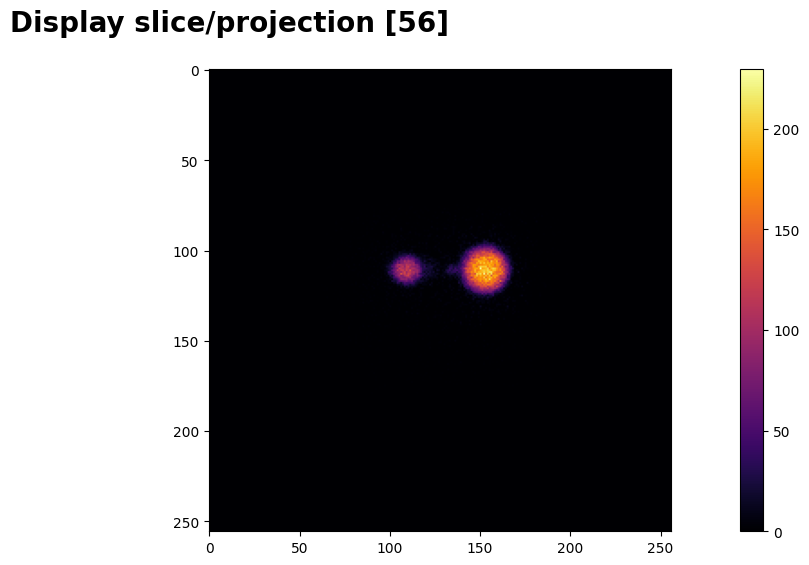

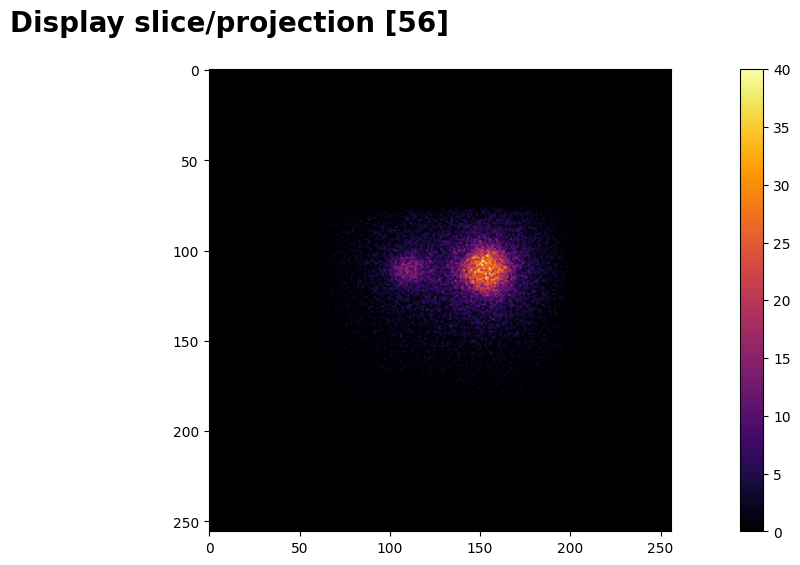

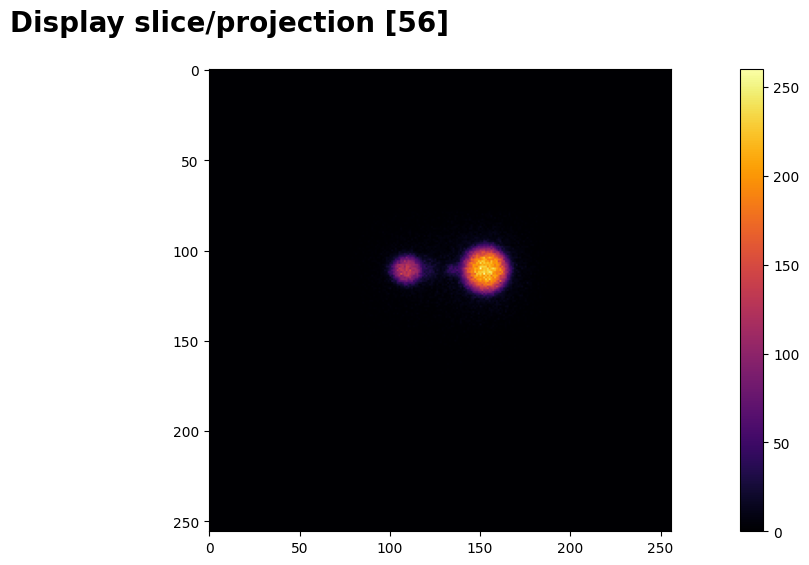

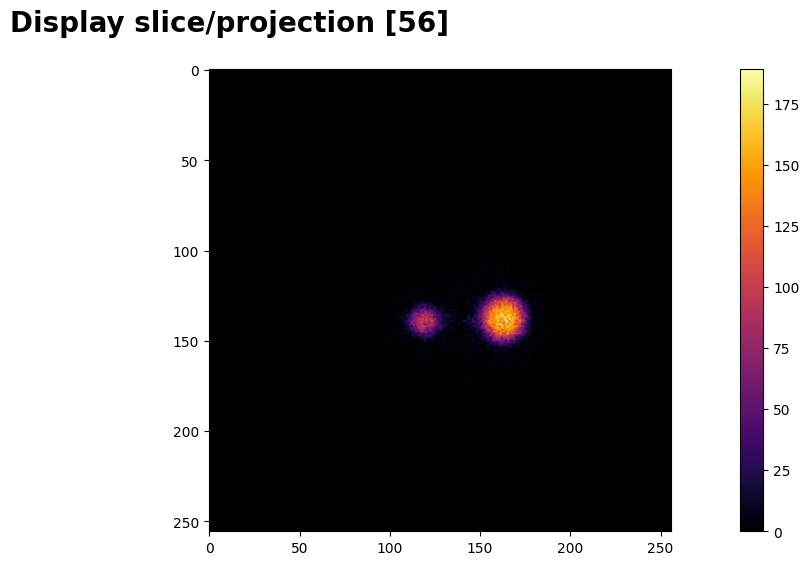

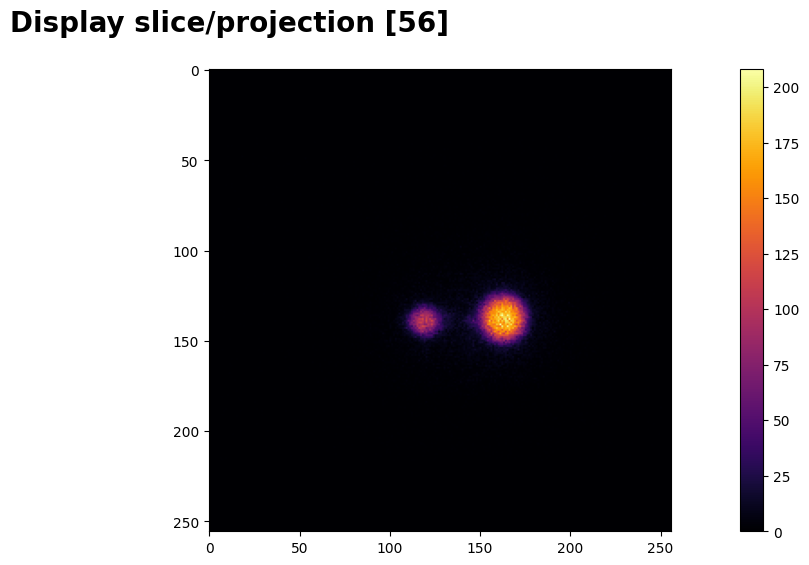

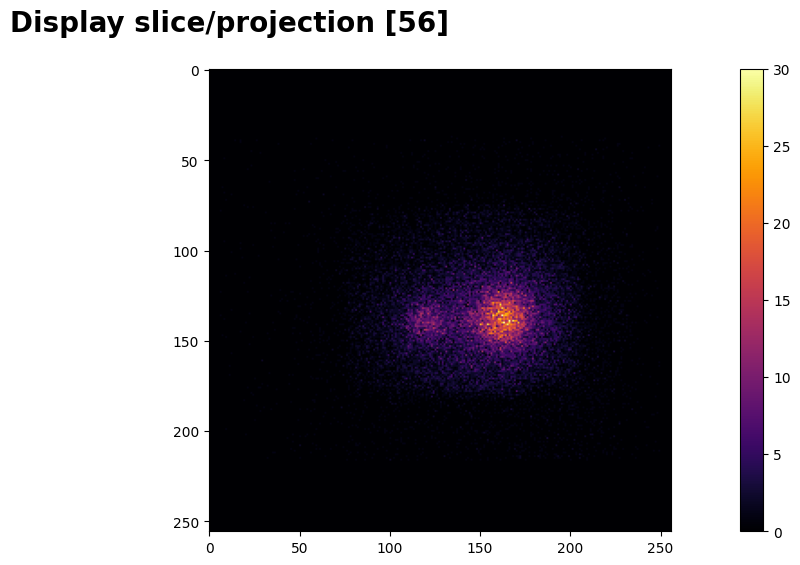

In [37]:
utils_ev.display(spect.AcquisitionData(str(output_dir / f"{output_prefix}_dew.hs")),56)
utils_ev.display(spect.AcquisitionData(str(output_dir / f"{output_prefix}_tot_w1_noise.hs")),56)
utils_ev.display(spect.AcquisitionData(str(output_dir / f"{output_prefix}_tot_w2_noise.hs")),56)
utils_ev.display(spect.AcquisitionData("/home/evarzaki/PROJECTS/_CLONED_Repositories/STIR_EARL_demo/measured_data/tc99m/earl_tc99m_dew.hs"),56)
utils_ev.display(spect.AcquisitionData("/home/evarzaki/PROJECTS/_CLONED_Repositories/STIR_EARL_demo/measured_data/tc99m/earl_tc99m_em_en_1_Tc99m_EM.hdr"),56)
utils_ev.display(spect.AcquisitionData("/home/evarzaki/PROJECTS/_CLONED_Repositories/STIR_EARL_demo/measured_data/tc99m/earl_tc99m_sc_en_1_Tc99m_SC.hdr"),56)

print(spect.AcquisitionData(str(output_dir / f"{output_prefix}_dew.hs")).as_array().sum())